# Homework 2: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [94]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [95]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = os.path.join('/Volumes/LK/modeling', 'Version4', 'Release4', 'interp_monthly', 'SSHDYN')

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [96]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
January_1992_file = os.path.join(ssh_folder, "SSHDYN_1992_01.nc")
ds = xr.open_dataset(January_1992_file)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
SSH_JAN_1992 = np.array(ds['SSHDYN'][:])
ds.close()
# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
January_2017_file = os.path.join(ssh_folder, "SSHDYN_2017_01.nc")
ds = xr.open_dataset(January_2017_file)
SSH_JAN_2017 = np.array(ds['SSHDYN'][:])
ds.close()

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

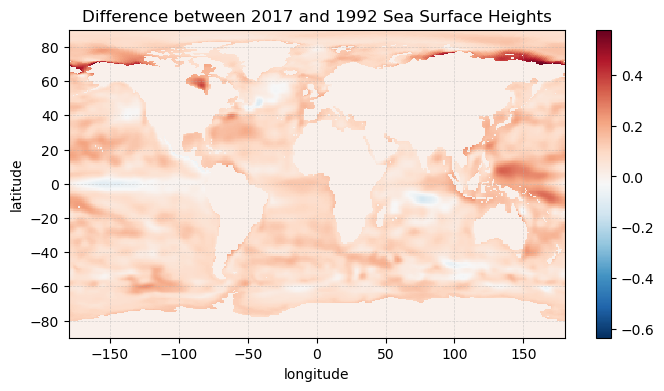

In [97]:
# make a plot of the differences between 2017 and 1992
fig = plt.figure(figsize=(8,4))

#sea surface hieght difference
SSH_diff = SSH_JAN_2017[0, :, :] - SSH_JAN_1992[0, :, :]

#color bounds equal in both directions
v = np.nanmax(np.abs(SSH_diff))

#plot
plt.pcolormesh(longitude, latitude, SSH_diff, cmap='RdBu_r', vmin=v, vmax=-v, shading="auto")

# add a colorbar
plt.colorbar()

# format the axes
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Difference between 2017 and 1992 Sea Surface Heights')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: The largest increases in sea level are observed along the coastlines in the artic ocean.
The sea surface heigh has decreased along the equator.

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [98]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lon_index = np.argmin(np.abs(lon - longitude))
lat_index = np.argmin(np.abs(lat - latitude))
print('Nearest latitude:',longitude[lon_index])
print('Nearest longitude:',latitude[lat_index])

Nearest latitude: -122.25
Nearest longitude: 36.75


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

In [99]:
#create a timeseries of ssh at the point above by looping through all of the ssh files
#make a list to contain the file names
ssh_values = []
times = []

#loop through each file
for file_name in file_list:
    
    #identify path to the data file
    data_file = os.path.join(ssh_folder, file_name)
    
    #read in the data 
    ds = xr.open_dataset(data_file)
    ssh_data = np.array(ds['SSHDYN'][:])
    ds.close()

    #add the data point from the CA coast location
    ssh_point = ssh_data[0, lat_index, lon_index]
    ssh_values.append(ssh_point)

months = np.arange(len(global_ssh_values))
times = 1992 + months/12

# convert lists to numpy arrays
ssh_values = np.array(ssh_values)
times = np.array(times)

# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
timeseries = np.zeros((len(times), 2), dtype=object)  # <-- NEW
timeseries[:, 0] = times
timeseries[:, 1] = ssh_values

print("Timeseries shape:", timeseries.shape)

Timeseries shape: (312, 2)


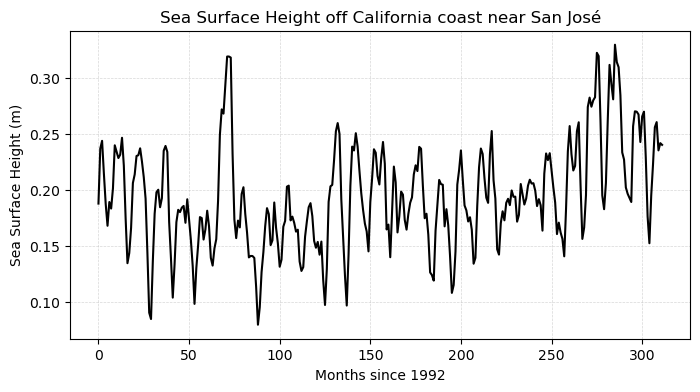

In [100]:
# make a figure
fig = plt.figure(figsize=(8,4))

plt.plot(ssh_values, 'k-')

# format the axes
plt.ylabel('Sea Surface Height (m)')
plt.xlabel('Months since 1992')
plt.title('Sea Surface Height off California coast near San José')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

In [101]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
global_ssh_values = []
times = []

#loop through each file
for file_name in file_list:
    
    #identify path to the data file
    data_file = os.path.join(ssh_folder, file_name)
    
    #read in the data 
    ds = xr.open_dataset(data_file)
    ssh_data = np.array(ds['SSHDYN'][:])
    ds.close()
    
    # each time through the loop, take the mean of the ssh grid at the row and column identified above
    # when you take the mean, be sure to exclude 0 values, which pertain to land
    arr = ssh_data[0, :, :] if ssh_data.ndim == 3 else ssh_data   ### NEW: handle 3D or 2D
    ssh_mean = np.nanmean(np.where(arr == 0, np.nan, arr))

    global_ssh_values.append(ssh_mean)

months = np.arange(len(global_ssh_values))
times = 1992 + months/12

# convert lists to numpy arrays
global_ssh_values = np.array(global_ssh_values)
times = np.array(times)

# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
timeseries = np.zeros((len(times), 2), dtype=object)
timeseries[:, 0] = times
timeseries[:, 1] = global_ssh_values

print("Timeseries shape:", timeseries.shape)

Timeseries shape: (312, 2)


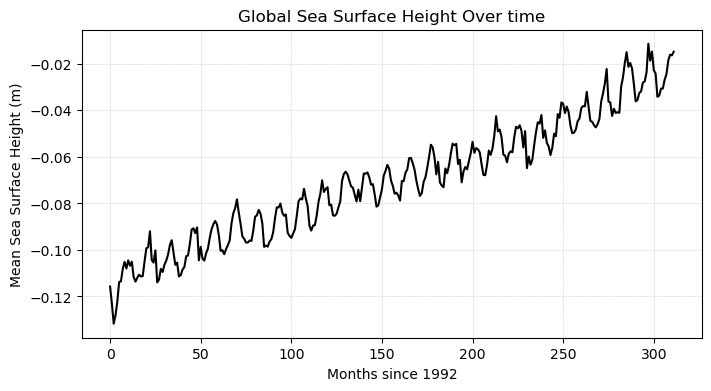

In [102]:
# make a figure
fig = plt.figure(figsize=(8,4))

plt.plot(global_ssh_values, 'k-')

# format the axes
plt.ylabel('Mean Sea Surface Height (m)')
plt.xlabel('Months since 1992')
plt.title('Global Sea Surface Height Over time')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [103]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
line_coeff_cali = np.polyfit(times, ssh_values, deg=1)
line_coeff_global = np.polyfit(times, global_ssh_values, deg=1)


# print out the statistics in mm/yr for each timeseries
print('Sea level rise in California (mm/yr):', line_coeff_cali[0]*1000)
print('Global Sea level rise (mm/yr):', line_coeff_global[0]*1000)

Sea level rise in California (mm/yr): 2.078105891240097
Global Sea level rise (mm/yr): 3.3768145808179106


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: The global sea level is rising more than in California, so there are other locations where sea level is rising much more driving the global mean up.

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

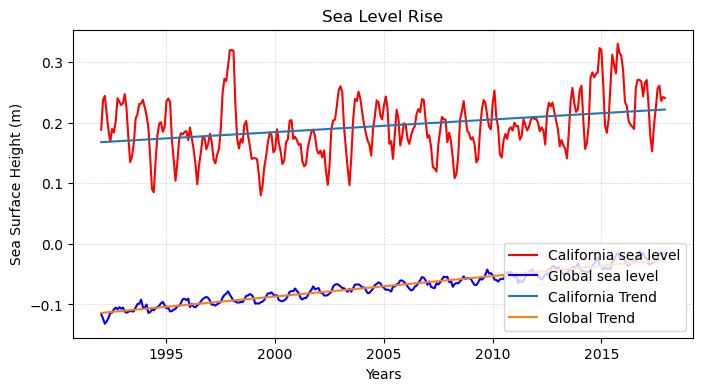

In [104]:
# create your plot here
# make a figure
fig = plt.figure(figsize=(8,4))

plt.plot(times, ssh_values, 'r', label='California sea level')
plt.plot(times, global_ssh_values, 'b', label='Global sea level')

plt.plot(times, line_coeff_cali[0] * times + line_coeff_cali[1], label='California Trend')
plt.plot(times, line_coeff_global[0] * times + line_coeff_global[1], label='Global Trend')

plt.legend(loc = 4)

# format the axes
plt.ylabel('Sea Surface Height (m)')
plt.xlabel('Years')
plt.title('Sea Level Rise')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: Both timeseries are increasing, however the California timeseries shows small scale regional variations such as specific weather events, upwelling/downwelling, and winds. The global variability is much smaller and seasonal due to averaging over the globe.
There was a very high year in 1997 and 2015, these correlate to strong eastern Pacific El Nino events that lead to the ocean warming and subsequenchially expanding to produce higher sea level.